In [61]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
from functools import partial, reduce
import benchmarks
from typing import List, Tuple, Callable

Function to optimize :  mccormick
Dimension :  2
Search space :  [-1.5, -1.5] [4, 4]


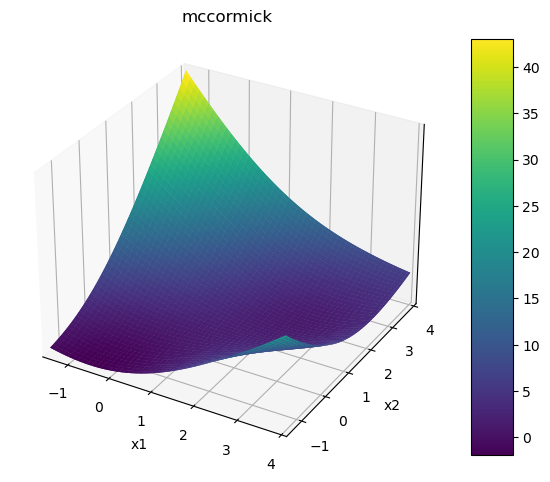

In [62]:
# Evaluation function
FUNCTION = benchmarks.mccormick  # function to optimize

DIM = 2  # problem dimension
# domain of variation definition
INFS, SUPS = benchmarks.get_domain_by_function_name(FUNCTION.__name__, DIM)  # search space

print("Function to optimize : ", FUNCTION.__name__)
print("Dimension : ", DIM)
print("Search space : ", INFS, SUPS)


def viz_3D_function(func, infs, sups, title=""):
    """
    Plot the function in the search space.
    """
    # square figure
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    # plot function
    x = np.linspace(infs[0], sups[0], 100)
    y = np.linspace(infs[1], sups[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func(np.array([X[i, j], Y[i, j]])) for i in range(X.shape[0]) for j in range(X.shape[1])]).reshape(
        X.shape)

    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    # add range bar on the right
    fig.colorbar(ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none'), ax=ax, shrink=0.9, aspect=10)
    # Plot the swarm (top view)
    ax.set_xlim(infs[0], sups[0])
    ax.set_ylim(infs[1], sups[1])
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(title)
    # hide z axis
    ax.set_zticks([])
    plt.show()


viz_3D_function(FUNCTION, INFS, SUPS, title=FUNCTION.__name__)

## Initializations

In [63]:
# Initialisation d'une solution aléatoire de dimension dim
def init_individual(dim, infs, sups):
    return np.array([random.uniform(infs[i], sups[i]) for i in range(dim)])


# Initialisation d'une population de n individus
def init_population(n, dim, infs, sups):
    return [init_individual(dim, infs, sups) for _ in range(n)]


population_test = init_population(10, 2, INFS, SUPS)
population_test

[array([-0.12305951,  1.55679877]),
 array([-0.93975374,  2.74658435]),
 array([ 2.56622681, -1.28248426]),
 array([2.64535054, 2.09732916]),
 array([3.68949502, 2.51645183]),
 array([-1.40493744,  1.68123022]),
 array([ 1.50892109, -1.05904333]),
 array([-0.28481421,  2.74913056]),
 array([ 0.80698866, -0.54434283]),
 array([1.3906164 , 1.32574213])]

### Plot population

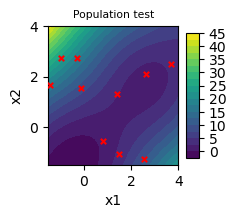

In [121]:
def plot_population(population: list, dim: int, infs: list, sups: list, eval_func=FUNCTION,
                    title: str = "Population", coef_figsize=1):
    """
    Plot the swarm in the search space.
    """
    if (dim > 2):
        print("Plotting is only possible for 2D and 3D problems")
        return

    if (dim == 2):
        # square figure
        fig, ax = plt.subplots(figsize=(7 * coef_figsize, 6 * coef_figsize))
        # plot function
        x = np.linspace(infs[0], sups[0], 100)
        y = np.linspace(infs[1], sups[1], 100)
        X, Y = np.meshgrid(x, y)
        Z = eval_func(np.array([X, Y]))
        ax.contour(X, Y, Z, 20, cmap='viridis', zorder=0)
        # add range bar on the right
        fig.colorbar(ax.contourf(X, Y, Z, 20, cmap='viridis'), ax=ax, shrink=0.9, aspect=10)
        # Plot the swarm (top view)
        ax.set_xlim(infs[0], sups[0])
        ax.set_ylim(infs[1], sups[1])
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(title, fontsize=26 * coef_figsize)
        # Plot the swarm
        for ind in population:
            ax.scatter(ind[0], ind[1], color="red", s=50 * coef_figsize, zorder=10, marker="x")

    plt.show()


plot_population(population_test, 2, INFS, SUPS, title="Population test", coef_figsize=0.3)

## Operators

In [64]:
def is_better(ind1: np.ndarray, ind2: np.ndarray, func: Callable) -> bool:
    """
    Return True if ind1 is better than ind2.
    """
    return func(ind1) < func(ind2)


def max_individual(ind1: np.ndarray, ind2: np.ndarray, func: Callable) -> np.ndarray:
    """
    Return the best individual between ind1 and ind2.
    """
    if is_better(ind1, ind2, func):
        return ind1
    else:
        return ind2


def get_best_individual(population: List[np.ndarray], func: Callable) -> Tuple[np.ndarray, float]:
    """
    Return the best individual
    """
    return reduce(partial(max_individual, func=func), population)


get_best_individual(population_test, FUNCTION)

array([ 0.80698866, -0.54434283])

In [65]:
# Sélection de n individus différents de x
def select_n_individuals(population: List[np.ndarray], x: np.ndarray, n: int) -> List[np.ndarray]:
    individuals = []
    if n > len(population):
        raise ValueError("n must be lower than the population size")
    while len(individuals) < n:
        individual = random.choice(population)
        if not np.array_equal(individual, x) and tuple(individual) not in map(tuple, individuals):
            individuals.append(individual)
    return individuals


select_n_individuals(population_test, population_test[0], 9)

[array([-0.93975374,  2.74658435]),
 array([-1.40493744,  1.68123022]),
 array([3.68949502, 2.51645183]),
 array([-0.28481421,  2.74913056]),
 array([ 2.56622681, -1.28248426]),
 array([1.3906164 , 1.32574213]),
 array([2.64535054, 2.09732916]),
 array([ 1.50892109, -1.05904333]),
 array([ 0.80698866, -0.54434283])]

### Mutation

In [66]:
# Fonction de mutation (différence entre 2 individus + facteur d'échelle * différence entre 2 autres individus)
# Mutation de type de/rand/1
def mutation_rand_1(x: np.ndarray, population: List[np.ndarray], F: float) -> np.ndarray:
    xr1, xr2, xr3 = select_n_individuals(population, x, 3)
    v = xr1 + F * (xr2 - xr3)
    return v


# Mutation de type de/rand/2
def mutation_rand_2(x: np.ndarray, population: List[np.ndarray], F: float) -> np.ndarray:
    xr1, xr2, xr3, xr4, xr5 = select_n_individuals(population, x, 5)
    v = xr1 + F * (xr2 - xr3) + F * (xr4 - xr5)
    return v


# Mutation de type de/best/1
def mutation_best_1(x: np.ndarray, population: List[np.ndarray], F: float, x_best: np.ndarray) -> np.ndarray:
    xr1, xr2 = select_n_individuals(population, x, 2)
    v = x_best + F * (xr1 - xr2)
    return v


# Mutation de type de/best/2
def mutation_best_2(x: np.ndarray, population: List[np.ndarray], F: float, x_best: np.ndarray) -> np.ndarray:
    xr1, xr2, xr3, xr4 = select_n_individuals(population, x, 4)
    v = x_best + F * (xr1 - xr2) + F * (xr3 - xr4)
    return v


# Mutation de type de/target-to-best/1
def mutation_target_to_best_1(x: np.ndarray, population: List[np.ndarray], F: float, x_best: np.ndarray) -> np.ndarray:
    xr1, xr2 = select_n_individuals(population, x, 2)
    v = x + F * (x_best - x) + F * (xr1 - xr2)
    return v


# Mutation by strategy name
def mutation(x: np.ndarray, population: List[np.ndarray], F: float, x_best: np.ndarray, strategy: str) -> np.ndarray:
    if strategy == "rand/1":
        return mutation_rand_1(x, population, F)
    elif strategy == "rand/2":
        return mutation_rand_2(x, population, F)
    elif strategy == "best/1":
        return mutation_best_1(x, population, F, x_best)
    elif strategy == "best/2":
        return mutation_best_2(x, population, F, x_best)
    elif strategy == "target-to-best/1":
        return mutation_target_to_best_1(x, population, F, x_best)
    else:
        raise ValueError("Unknown mutation strategy")


# use np.clip to limit the values in the search space
def correct_solution(x: np.ndarray, infs: List[float], sups: List[float]) -> np.ndarray:
    return np.clip(x, infs, sups)


x_test = population_test[0]
print("Initial solution : ", x_test)
u_test = mutation(x_test, population_test, 0.5, get_best_individual(population_test, FUNCTION), "rand/1")
print("Mutated solution : ", u_test)
u_test = correct_solution(u_test, INFS, SUPS)
print("Corrected solution : ", u_test)

Initial solution :  [-0.12305951  1.55679877]
Mutated solution :  [ 0.57907219 -1.16614489]
Corrected solution :  [ 0.57907219 -1.16614489]


### Cross-over

In [67]:
# Fonction de croisement (si le coefficient aléatoire est inférieur à CR, on conserve la valeur de la fonction de mutation, sinon on conserve la valeur de x)
def crossover(x: np.ndarray, v: np.ndarray, CR: float) -> np.ndarray:
    """
    Crossover function
    :param x: current individual
    :param v: mutated individual
    :param CR: crossover rate
    """
    u = np.zeros(x.shape)
    for i in range(len(x)):
        if random.random() <= CR:
            u[i] = v[i]
        else:
            u[i] = x[i]
    return u


print("Initial solution : ", x_test)
print("Mutated solution : ", u_test)
print("Crossover solution : ", crossover(x_test, u_test, CR=0.5))

Initial solution :  [-0.12305951  1.55679877]
Mutated solution :  [ 0.57907219 -1.16614489]
Crossover solution :  [-0.12305951  1.55679877]


## DE algorithm

In [68]:
def evaluate_cohesion(population: list) -> float:
    """
    Return the average distance between all particles in the population.
    """
    num_particles = len(population)
    total_distance = 0
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            distance = np.linalg.norm(population[i] - population[j])  # euclidean distance
            total_distance += distance
    avg_distance = total_distance / (num_particles * (num_particles - 1) / 2)
    return avg_distance


evaluate_cohesion(population_test)

2.977310577825724

### Plotting functions

In [125]:
def print_solution(best: np.ndarray, eval_func: Callable[[np.ndarray], float]):
    print(f"  point = {best}")
    print(f"  value = {eval_func(best)}")


def plot_history(h_best_solution_fit, h_cohesion, h_amount_improvement, title=""):
    # Plot the evolution of the best fit and cohesion (subplots)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7))
    fig.suptitle(title)

    ax1.plot(h_best_solution_fit, color='green')
    ax1.set_title('Evolution of the best fit')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best fit')

    ax2.plot(h_cohesion, color='orange')
    ax2.set_title('Evolution of the cohesion')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Cohesion')

    ax3.plot(h_amount_improvement, color='red')
    ax3.set_title('Evolution of the amount of improvement')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Amount of improvement')

    fig.tight_layout()

    plt.show()


### Main algorithm

>>> Start DE algorithm
>>> Parameters :
 * pop_size = 50
 * dim = 2
 * eval_func = mccormick
 * F = 0.9
 * CR = 0.9
 * mutation_type = rand/1
 * max_iter = 25
 * max_iter_no_improvement = 15


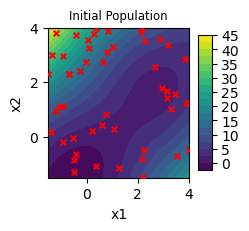

  0%|          | 0/25 [00:00<?, ?it/s]

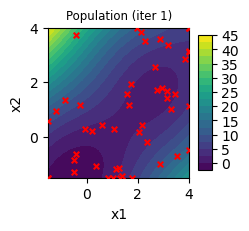

  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

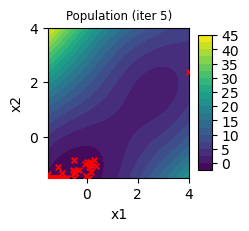

 20%|██        | 5/25 [00:03<00:13,  1.53it/s]

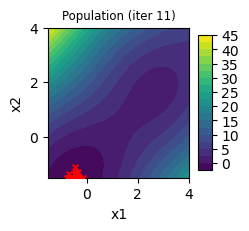

100%|██████████| 25/25 [00:04<00:00,  6.08it/s]


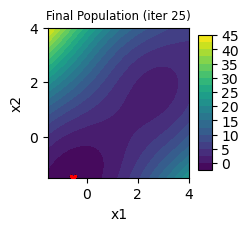

>>> Results after 24 iterations :
> Best solution since the beginning :
  point = [-0.52885615 -1.5       ]
  value = -1.9105075459094691
> Best solution at the end :
  point = [-0.52885615 -1.5       ]
  value = -1.9105075459094691
>>> Display history :


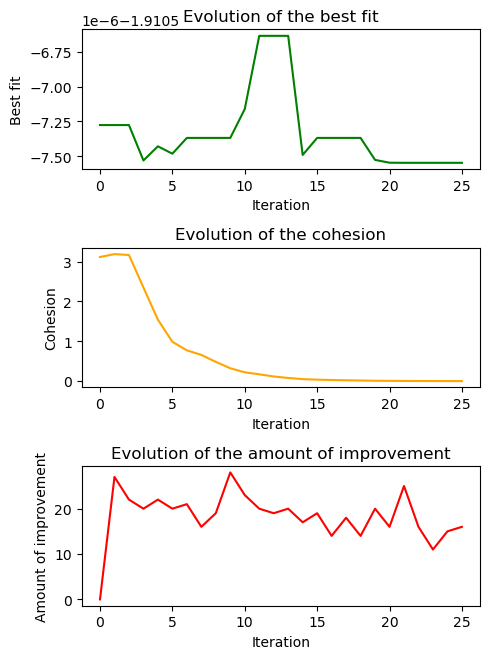

In [126]:

# Algorithme DE
def DE_algorithm(pop_size: int, dim: int, eval_func, F: float, CR: float,
                 mutation_type: str, infs: list, sups: list, max_iter: int = 1000,
                 max_iter_no_improvement: int = 15, display_iter_population_plots=True,
                 iter_population_plots: list = [], display_history=True,
                 verbose: bool = True):
    if verbose:
        print(">>> Start DE algorithm")
        print(">>> Parameters :")
        print(f" * pop_size = {pop_size}")
        print(f" * dim = {dim}")
        print(f" * eval_func = {eval_func.__name__}")
        print(f" * F = {F}")
        print(f" * CR = {CR}")
        print(f" * mutation_type = {mutation_type}")
        print(f" * max_iter = {max_iter}")
        print(f" * max_iter_no_improvement = {max_iter_no_improvement}")

    # mutation function
    if mutation_type not in ["rand/1", "rand/2", "best/1", "best/2"]:
        raise ValueError(f"Unknown mutation type : {mutation_type}")

    # initialization of the population
    population = init_population(pop_size, dim, infs, sups)
    plot_population(population, dim, infs, sups, eval_func=eval_func, title=f"Initial Population",
                    coef_figsize=0.325) if display_iter_population_plots else None
    history_population = [population[:]]
    history_cohesion = [evaluate_cohesion(population)]
    # initialization of the best individual
    best_solution = get_best_individual(population, eval_func)
    history_best_solution = [best_solution]

    history_amount_improvement = [0] # todo : change to percentage of improvement
    iter_no_improvement = 0
    if verbose:
        range_iter = tqdm(range(max_iter))
    else:
        range_iter = range(max_iter)

    for num_iter in range_iter:

        # update the population
        amount_improvement = 0
        for x in population:
            # mutation
            u = correct_solution(
                mutation(x=x, population=population, F=F, strategy=mutation_type, x_best=best_solution), infs, sups)
            # crossover
            x_new = crossover(x, u, CR)
            # selection
            if is_better(x_new, x, eval_func):
                x[:] = x_new
                amount_improvement += 1

        # get the best solution
        best_solution = get_best_individual(population, eval_func)

        # plot the swarm
        plot_population(population, dim, infs, sups, eval_func=eval_func, title=f"Population (iter {num_iter + 1})",
                        coef_figsize=0.325) if num_iter in iter_population_plots else None

        # historization
        history_best_solution.append(best_solution)
        history_cohesion.append(evaluate_cohesion(population))
        history_population.append(population[:])
        history_amount_improvement.append(amount_improvement)

        # check if no improvement since a while
        if not is_better(history_best_solution[-1], history_best_solution[-2], eval_func):
            iter_no_improvement += 1
            #print(f">>> No improvement since {iter_no_improvement} iterations")
            if iter_no_improvement >= max_iter_no_improvement:
                if verbose:
                    print(f">>> Break : no improvement since {max_iter_no_improvement} iterations")
                break
        else:
            iter_no_improvement = 0

    # final plot
    plot_population(population, dim, infs, sups, eval_func=eval_func, title=f"Final Population (iter {num_iter + 1})",
                    coef_figsize=0.325) if display_iter_population_plots else None
    # get the best solution since the beginning and at the end
    best_since_beginning = get_best_individual(history_best_solution, eval_func)
    best_at_end = get_best_individual(population, eval_func)
    # display result
    if verbose:
        print(">>> Results after", num_iter, "iterations :")
        print("> Best solution since the beginning :")
        print_solution(best_since_beginning, eval_func)
        print("> Best solution at the end :")
        print_solution(best_at_end, eval_func)

    # display history
    if display_history:
        print(">>> Display history :")
        plot_history([eval_func(x) for x in history_best_solution], history_cohesion, history_amount_improvement)
    return best_since_beginning, best_at_end, history_best_solution, history_cohesion, history_population


# Exemple d'utilisation de l'algorithme DE
best_since_beginning, best_at_end, history_best_solution, history_cohesion, history_population = DE_algorithm(
    pop_size=50, dim=DIM, eval_func=FUNCTION, F=0.9, CR=0.9, mutation_type="rand/1",
    infs=INFS, sups=SUPS, max_iter=25, max_iter_no_improvement=15, iter_population_plots=[0, 4, 10, 50],
    verbose=True)

## Multiple execution

### with different parameters

######################################################################
Mutation type : rand/1
######################################################################
>>> Start DE algorithm
>>> Parameters :
 * pop_size = 25
 * dim = 2
 * eval_func = mccormick
 * F = 0.5
 * CR = 0.9
 * mutation_type = rand/1
 * max_iter = 250
 * max_iter_no_improvement = 50


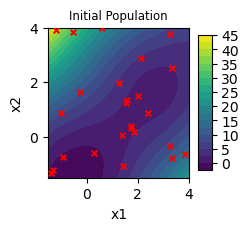

  0%|          | 0/250 [00:00<?, ?it/s]

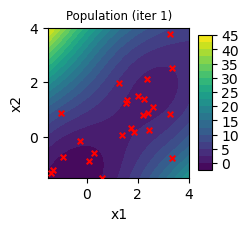

  1%|          | 3/250 [00:01<01:34,  2.61it/s]

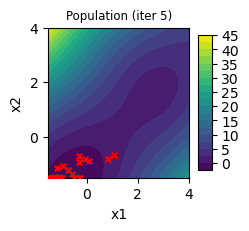

  2%|▏         | 5/250 [00:02<02:15,  1.80it/s]

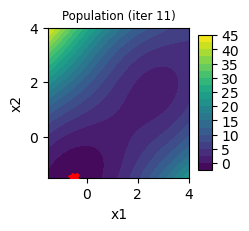

 20%|█▉        | 49/250 [00:05<00:08, 25.11it/s]

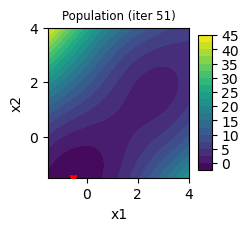

 34%|███▍      | 85/250 [00:07<00:13, 11.87it/s]


>>> Break : no improvement since 50 iterations


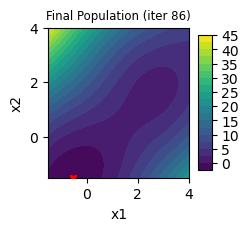

>>> Results after 85 iterations :
> Best solution since the beginning :
  point = [-0.52888341 -1.5       ]
  value = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888341 -1.5       ]
  value = -1.9105075469843982
>>> Display history :


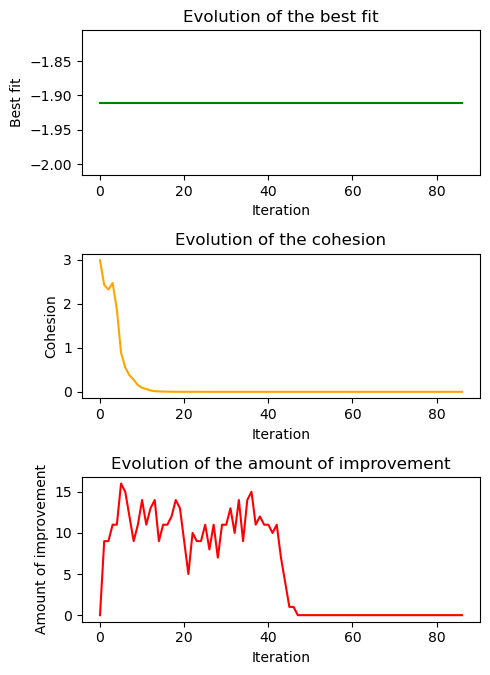

######################################################################
Mutation type : rand/2
######################################################################
>>> Start DE algorithm
>>> Parameters :
 * pop_size = 25
 * dim = 2
 * eval_func = mccormick
 * F = 0.5
 * CR = 0.9
 * mutation_type = rand/2
 * max_iter = 250
 * max_iter_no_improvement = 50


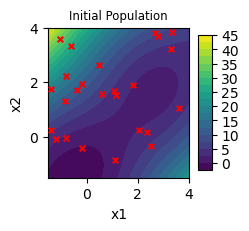

  0%|          | 0/250 [00:00<?, ?it/s]

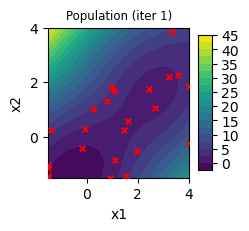

  0%|          | 1/250 [00:01<04:18,  1.04s/it]

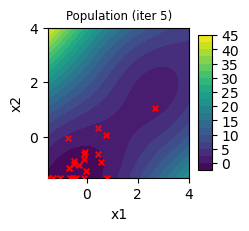

  2%|▏         | 5/250 [00:02<01:28,  2.76it/s]

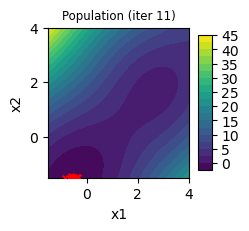

 18%|█▊        | 45/250 [00:03<00:06, 29.45it/s]

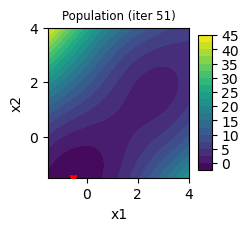

 36%|███▋      | 91/250 [00:05<00:08, 17.87it/s]


>>> Break : no improvement since 50 iterations


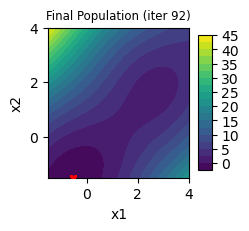

>>> Results after 91 iterations :
> Best solution since the beginning :
  point = [-0.5288834 -1.5      ]
  value = -1.9105075469843982
> Best solution at the end :
  point = [-0.5288834 -1.5      ]
  value = -1.9105075469843982
>>> Display history :


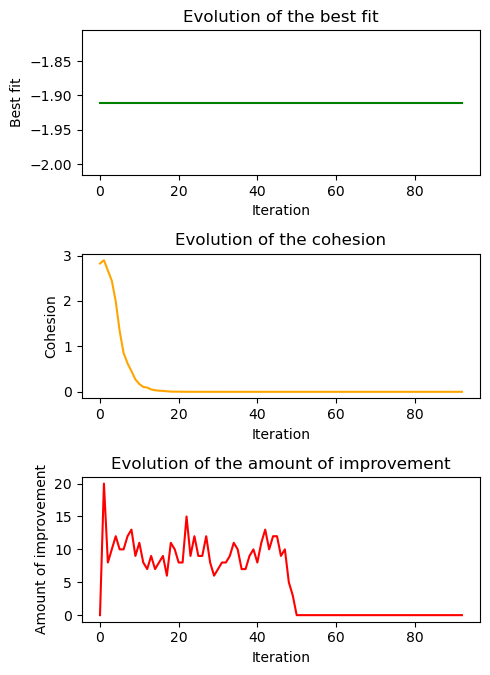

######################################################################
Mutation type : best/1
######################################################################
>>> Start DE algorithm
>>> Parameters :
 * pop_size = 25
 * dim = 2
 * eval_func = mccormick
 * F = 0.5
 * CR = 0.9
 * mutation_type = best/1
 * max_iter = 250
 * max_iter_no_improvement = 50


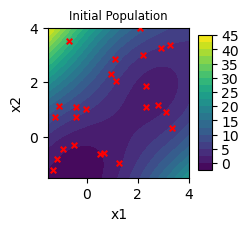

  0%|          | 0/250 [00:00<?, ?it/s]

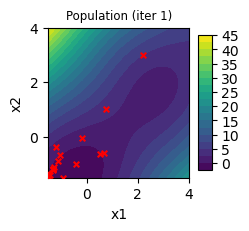

  0%|          | 1/250 [00:01<04:13,  1.02s/it]

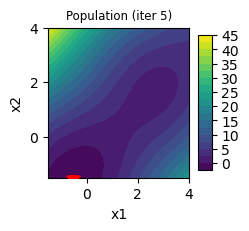

  2%|▏         | 5/250 [00:02<01:30,  2.72it/s]

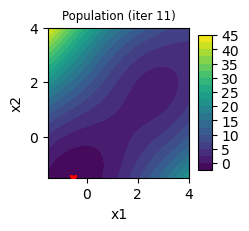

 16%|█▋        | 41/250 [00:03<00:09, 21.83it/s]

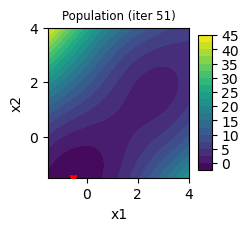

 28%|██▊       | 69/250 [00:04<00:12, 14.59it/s]


>>> Break : no improvement since 50 iterations


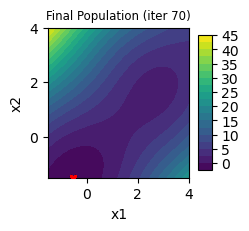

>>> Results after 69 iterations :
> Best solution since the beginning :
  point = [-0.52888341 -1.5       ]
  value = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888341 -1.5       ]
  value = -1.9105075469843982
>>> Display history :


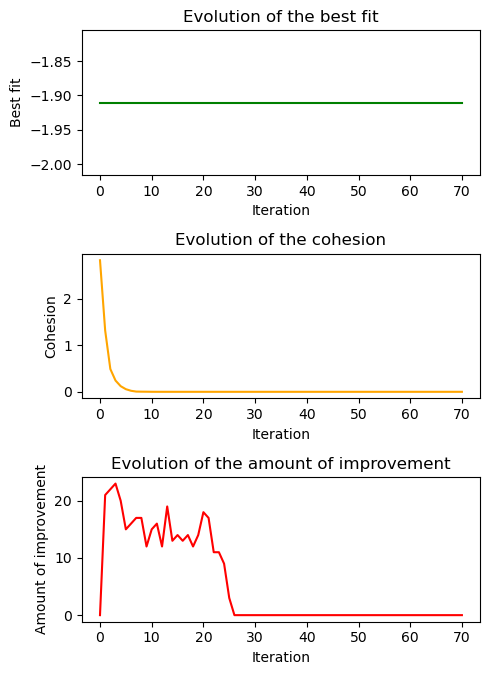

######################################################################
Mutation type : best/2
######################################################################
>>> Start DE algorithm
>>> Parameters :
 * pop_size = 25
 * dim = 2
 * eval_func = mccormick
 * F = 0.5
 * CR = 0.9
 * mutation_type = best/2
 * max_iter = 250
 * max_iter_no_improvement = 50


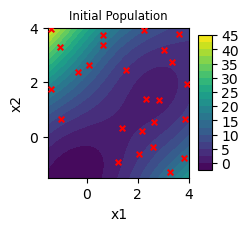

  0%|          | 0/250 [00:00<?, ?it/s]

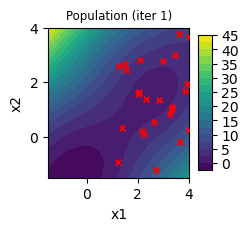

  0%|          | 1/250 [00:01<04:57,  1.20s/it]

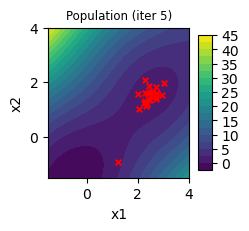

  2%|▏         | 5/250 [00:02<01:31,  2.69it/s]

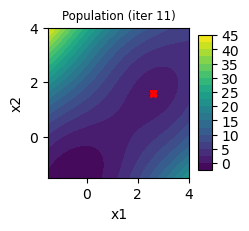

 19%|█▉        | 47/250 [00:03<00:07, 28.59it/s]

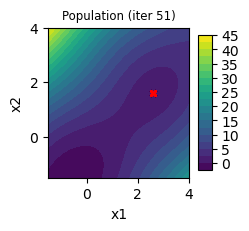

 37%|███▋      | 92/250 [00:04<00:08, 19.70it/s]


>>> Break : no improvement since 50 iterations


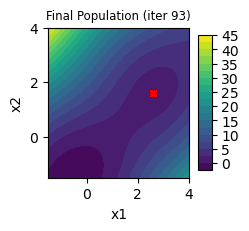

>>> Results after 92 iterations :
> Best solution since the beginning :
  point = [2.5943951  1.59439512]
  value = 1.2283696986087564
> Best solution at the end :
  point = [2.5943951  1.59439512]
  value = 1.2283696986087564
>>> Display history :


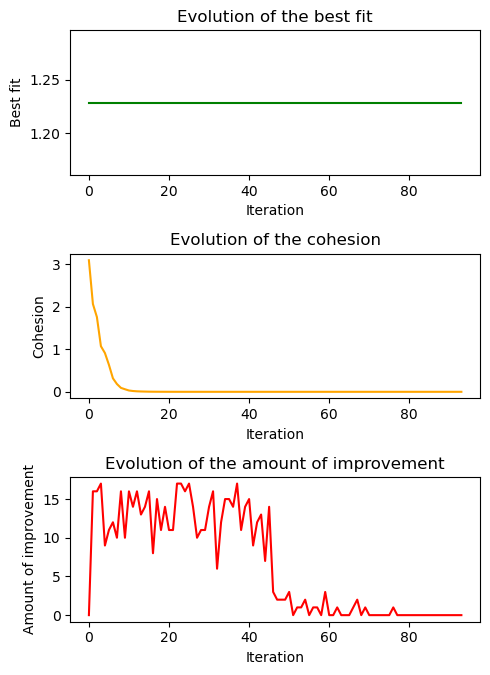

In [128]:
for mutation_type in ["rand/1", "rand/2", "best/1", "best/2"]:
    print("#" * 70)
    print(f"Mutation type : {mutation_type}")
    print("#" * 70)
    DE_algorithm(pop_size=25, dim=DIM, eval_func=FUNCTION, F=0.5, CR=0.9, mutation_type=mutation_type,
                 infs=INFS, sups=SUPS, max_iter=250, max_iter_no_improvement=50, iter_population_plots=[0, 4, 10, 50],
                 verbose=True)


### with same parameters

#### Display results